<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4/%EB%AC%B8%EC%A0%9C13_%EA%B5%AD%EB%82%B4%EC%BD%94%EB%A1%9C%EB%82%9819_%ED%99%95%EC%A7%84%EC%9E%90%EC%98%88%EC%B8%A1%EB%B6%84%EC%84%9D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 국내코로나19 확진자예측분석 (시계열문제유형)


### Step 0. 필요패키지 설치 및 데이터 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
from scipy import stats

##  Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# keras 시계열 딥러닝 관련
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'chumdan'
os.environ['KAGGLE_KEY'] = '0e8bf51ba50bce898a8a9736072bd3b8'

In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!rm *.*
!kaggle datasets download -d antgoldbloom/covid19-data-from-john-hopkins-university
!unzip '*.zip'

rm: cannot remove '*.*': No such file or directory
100% 4.15M/4.15M [00:00<00:00, 4.91MB/s]

Archive:  covid19-data-from-john-hopkins-university.zip
  inflating: CONVENIENT_global_confirmed_cases.csv  
  inflating: CONVENIENT_global_deaths.csv  
  inflating: CONVENIENT_global_metadata.csv  
  inflating: CONVENIENT_us_confirmed_cases.csv  
  inflating: CONVENIENT_us_deaths.csv  
  inflating: CONVENIENT_us_metadata.csv  
  inflating: RAW_global_confirmed_cases.csv  
  inflating: RAW_global_deaths.csv   
  inflating: RAW_us_confirmed_cases.csv  
  inflating: RAW_us_deaths.csv       


In [ ]:
df_case = pd.read_csv('RAW_global_confirmed_cases.csv')
df_death = pd.read_csv('RAW_global_deaths.csv')

In [ ]:
df_case.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21
0,Afghanistan,NaN,33.94,67.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153
1,Albania,NaN,41.15,20.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544
2,Algeria,NaN,28.03,1.66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255
3,Andorra,NaN,42.51,1.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545
4,Angola,NaN,-11.20,17.87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757


In [ ]:
df_death.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,...,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21
0,Afghanistan,NaN,33.94,67.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2446,2446,2449,2449,2449,2451,2451,2451,2451,2454,2454,2457,2459,2460,2460,2462,2462,2462,2463,2464
1,Albania,NaN,41.15,20.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1856,1876,1897,1918,1939,1956,1969,1986,2002,2018,2030,2045,2060,2077,2092,2106,2122,2133,2137,2145
2,Algeria,NaN,28.03,1.66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2996,3002,3007,3010,3013,3018,3022,3026,3028,3031,3034,3036,3040,3045,3048,3051,3053,3055,3057,3061
3,Andorra,NaN,42.51,1.52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,112,112,112,112,112,112,112,112,112,112,112,113,113,113,113,113,113,113,113,113
4,Angola,NaN,-11.20,17.87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,510,511,511,512,514,515,516,516,517,519,520,521,521,522,522,522,524,526,527,530


### Step 1. 데이터 구조 변경 및 시각화하기

#### 나라별 확진자 수 및 사망자 수 시각화하기

In [ ]:
#### 문자타입을 시간정보 변경

In [ ]:
df_case = df_case.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [ ]:
df_case.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,...,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757


In [ ]:
df_case = df_case.transpose()

In [ ]:
df_case

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,...,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/18/21,56044,119528,115842,11393,21558,1008,2226753,181165,29183,504581,243424,8800,133779,564939,3492,306524,822801,12399,6501,868,...,27494,229,8582,7812,243935,2950603,29668587,40625,1553659,434465,4294328,76816,80971,3,148208,2570,218061,3126,85889,36611
3/19/21,56069,120022,115970,11431,21642,1011,2234913,182056,29192,508096,244303,8800,134510,566838,3512,307938,827941,12400,6818,868,...,27594,252,8695,7821,244776,2971633,29730000,40651,1569596,436625,4299200,78401,81095,3,149145,2571,219912,3217,86059,36652
3/20/21,56093,120541,116066,11481,21696,1033,2241739,183127,29196,511440,245490,8800,135326,568706,3533,309293,827941,12400,6818,869,...,27713,271,8839,7839,245405,2992694,29785285,40651,1584972,438638,4304839,79923,81339,3,150306,2572,221391,3278,86273,36662
3/21/21,56103,121200,116157,11517,21733,1033,2245771,183713,29206,514153,246304,8800,135982,570878,3551,310445,837006,12400,6818,869,...,27803,326,8918,7855,245706,3013122,29818930,40671,1596201,440355,4310195,81537,81339,3,151123,2572,223638,3418,86449,36665


In [ ]:
 df_case.index.name = 'datetime'

In [ ]:
df_case.reset_index(inplace=True)

In [ ]:
df_case

Country/Region,datetime,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,...,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2,1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
3,1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
4,1/26/20,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,3/18/21,56044,119528,115842,11393,21558,1008,2226753,181165,29183,504581,243424,8800,133779,564939,3492,306524,822801,12399,6501,...,27494,229,8582,7812,243935,2950603,29668587,40625,1553659,434465,4294328,76816,80971,3,148208,2570,218061,3126,85889,36611
422,3/19/21,56069,120022,115970,11431,21642,1011,2234913,182056,29192,508096,244303,8800,134510,566838,3512,307938,827941,12400,6818,...,27594,252,8695,7821,244776,2971633,29730000,40651,1569596,436625,4299200,78401,81095,3,149145,2571,219912,3217,86059,36652
423,3/20/21,56093,120541,116066,11481,21696,1033,2241739,183127,29196,511440,245490,8800,135326,568706,3533,309293,827941,12400,6818,...,27713,271,8839,7839,245405,2992694,29785285,40651,1584972,438638,4304839,79923,81339,3,150306,2572,221391,3278,86273,36662
424,3/21/21,56103,121200,116157,11517,21733,1033,2245771,183713,29206,514153,246304,8800,135982,570878,3551,310445,837006,12400,6818,...,27803,326,8918,7855,245706,3013122,29818930,40671,1596201,440355,4310195,81537,81339,3,151123,2572,223638,3418,86449,36665


In [ ]:
if 'datetime' in df_case.columns:
    df_case['datetime'] = pd.to_datetime(df_case['datetime'])
    df_case['DateTime'] = pd.to_datetime(df_case['datetime']) # 다른 활용을 위해서, 하나 더 만듬.
df_case

Country/Region,datetime,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,...,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe,DateTime
0,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-22
1,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-01-23
2,2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-01-24
3,2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-01-25
4,2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2021-03-18,56044,119528,115842,11393,21558,1008,2226753,181165,29183,504581,243424,8800,133779,564939,3492,306524,822801,12399,6501,...,229,8582,7812,243935,2950603,29668587,40625,1553659,434465,4294328,76816,80971,3,148208,2570,218061,3126,85889,36611,2021-03-18
422,2021-03-19,56069,120022,115970,11431,21642,1011,2234913,182056,29192,508096,244303,8800,134510,566838,3512,307938,827941,12400,6818,...,252,8695,7821,244776,2971633,29730000,40651,1569596,436625,4299200,78401,81095,3,149145,2571,219912,3217,86059,36652,2021-03-19
423,2021-03-20,56093,120541,116066,11481,21696,1033,2241739,183127,29196,511440,245490,8800,135326,568706,3533,309293,827941,12400,6818,...,271,8839,7839,245405,2992694,29785285,40651,1584972,438638,4304839,79923,81339,3,150306,2572,221391,3278,86273,36662,2021-03-20
424,2021-03-21,56103,121200,116157,11517,21733,1033,2245771,183713,29206,514153,246304,8800,135982,570878,3551,310445,837006,12400,6818,...,326,8918,7855,245706,3013122,29818930,40671,1596201,440355,4310195,81537,81339,3,151123,2572,223638,3418,86449,36665,2021-03-21


In [ ]:
df_case.set_index('DateTime', inplace=True)


In [ ]:
df_case

Country/Region,datetime,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,...,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-24,2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-25,2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-26,2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18,2021-03-18,56044,119528,115842,11393,21558,1008,2226753,181165,29183,504581,243424,8800,133779,564939,3492,306524,822801,12399,6501,...,27494,229,8582,7812,243935,2950603,29668587,40625,1553659,434465,4294328,76816,80971,3,148208,2570,218061,3126,85889,36611
2021-03-19,2021-03-19,56069,120022,115970,11431,21642,1011,2234913,182056,29192,508096,244303,8800,134510,566838,3512,307938,827941,12400,6818,...,27594,252,8695,7821,244776,2971633,29730000,40651,1569596,436625,4299200,78401,81095,3,149145,2571,219912,3217,86059,36652
2021-03-20,2021-03-20,56093,120541,116066,11481,21696,1033,2241739,183127,29196,511440,245490,8800,135326,568706,3533,309293,827941,12400,6818,...,27713,271,8839,7839,245405,2992694,29785285,40651,1584972,438638,4304839,79923,81339,3,150306,2572,221391,3278,86273,36662


In [ ]:
df_death = df_death.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()
df_death = df_death.transpose()
df_death.index.name = 'datetime'
df_death.reset_index(inplace=True)

In [ ]:
df_death.head()

Country/Region,datetime,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,...,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
if 'datetime' in df_death.columns:
    df_death['datetime'] = pd.to_datetime(df_death['datetime'])
    df_death['DateTime'] = pd.to_datetime(df_death['datetime'])
df_death

Country/Region,datetime,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,...,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe,DateTime
0,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-22
1,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-23
2,2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-24
3,2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-25
4,2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2021-03-18,2462,2106,3051,113,522,27,54386,3301,909,8982,3314,186,491,8624,39,2130,22624,316,81,...,0,102,140,8490,29777,540047,334,30811,1424,126163,749,622,0,1467,35,2358,723,1175,1509,2021-03-18
422,2021-03-19,2462,2122,3053,113,524,27,54476,3320,909,9024,3325,186,493,8642,39,2139,22650,316,90,...,0,102,140,8506,29864,541144,334,31078,1428,126263,760,622,0,1475,35,2379,733,1178,1510,2021-03-19
423,2021-03-20,2462,2133,3055,113,526,28,54517,3332,909,9052,3339,186,498,8668,39,2148,22650,316,90,...,0,102,140,8526,29959,541927,334,31344,1433,126359,776,622,0,1483,35,2406,737,1178,1510,2021-03-20
424,2021-03-21,2463,2137,3057,113,527,28,54545,3348,909,9074,3351,186,500,8690,39,2157,22707,316,90,...,0,104,140,8546,30061,542359,334,31514,1438,126393,792,622,0,1493,35,2427,751,1179,1512,2021-03-21


In [ ]:
df_death.set_index('DateTime', inplace=True)

In [ ]:
# 나라별 시간에 따른 확진자 수 및 사망자 수 시각화하기
def plot_case_with_death(country):
  plt.plot(df_case.index, df_case[country], 'b-')
  plt.ylabel('Confirmed Cases', color='blue')
  plt.title(country + ' Cases & Deaths')
  plt.xlabel('Date')
  plt.xlim(right=df_case.index[-1]) # x리미트를 설정
  plt.ylim(0, df_case[country].max()*1.1) # y리미트를 설정

  ax = plt.gca()
  ax2 = ax.twinx()
  ax2.plot(df_death.index, df_death[country], 'r--')
  ax2.set_ylabel('Deaths', color='red')
  ax2.set_ylim(0, df_death[country].max()*1.3)
  plt.show()

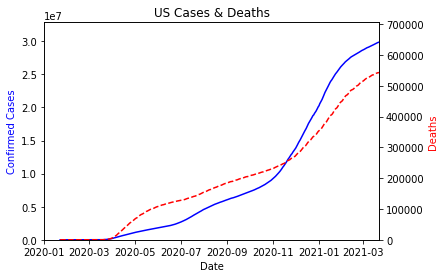

In [ ]:
# 한국의 누적 확진자 수/사망자 수를 시각화하고 분석하시오.
plot_case_with_death('US')

In [ ]:
for c in df_case.columns:
  print(c)

datetime
Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burma
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czechia
Denmark
Diamond Princess
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Holy See
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Korea, South
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
MS Zaandam
Madagascar
Malawi
Malaysia
Maldives

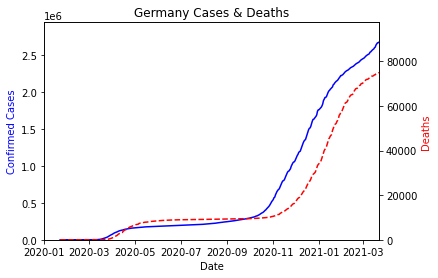

In [ ]:
plot_case_with_death('Germany')

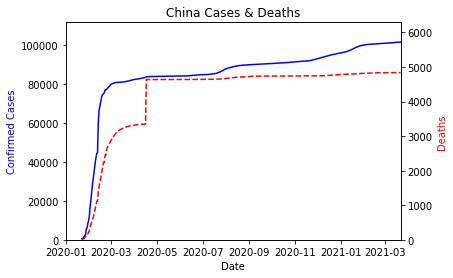

In [ ]:
plot_case_with_death('China')

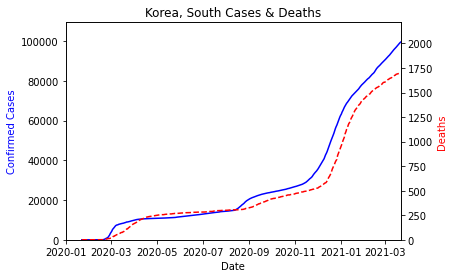

In [ ]:
# 한국의 누적 확진자 수/사망자 수
plot_case_with_death('Korea, South')

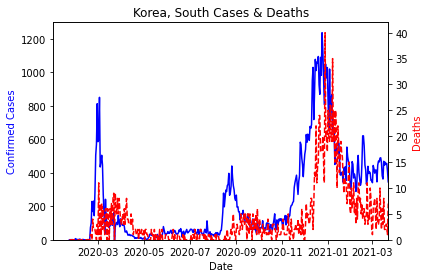

In [ ]:
# 한국 확진자 수 및 사망자 수 시각화하기
country = 'Korea, South'
plt.plot(df_case.index, df_case[country].diff(), 'b-') 
plt.ylabel('Confirmed Cases', color='blue')
plt.title(country + ' Cases & Deaths')
plt.xlabel('Date')
plt.xlim(right=df_case.index[-1])
plt.ylim(bottom=0)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index, df_death[country].diff(), 'r--')
ax2.set_ylabel('Deaths', color='red')
ax2.set_ylim(bottom=0)
plt.show()

## Step 2. 한국 데이터 분리 및 시계열 전처리 

In [ ]:
df_korea = pd.DataFrame(data=df_case, columns= ['datetime', 'Korea, South'])
df_korea

,datetime,"Korea, South"
DateTime,,
2020-01-22,2020-01-22,1
2020-01-23,2020-01-23,1
2020-01-24,2020-01-24,2
2020-01-25,2020-01-25,2
2020-01-26,2020-01-26,3
...,...,...
2021-03-18,2021-03-18,97757
2021-03-19,2021-03-19,98209
2021-03-20,2021-03-20,98665


In [ ]:
df_korea.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2020-01-22 to 2021-03-22
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      426 non-null    datetime64[ns]
 1   Korea, South  426 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.0 KB


In [ ]:
if df_korea.index.dtype == 'int64':
    df_korea.set_index('DateTime', inplace=True)
df_korea

,datetime,"Korea, South"
DateTime,,
2020-01-22,2020-01-22,1
2020-01-23,2020-01-23,1
2020-01-24,2020-01-24,2
2020-01-25,2020-01-25,2
2020-01-26,2020-01-26,3
...,...,...
2021-03-18,2021-03-18,97757
2021-03-19,2021-03-19,98209
2021-03-20,2021-03-20,98665


#### 빈도추출

In [ ]:
df_korea.asfreq('D').isnull().sum()

datetime        0
Korea, South    0
dtype: int64

In [ ]:
df_korea

,datetime,"Korea, South"
DateTime,,
2020-01-22,2020-01-22,1
2020-01-23,2020-01-23,1
2020-01-24,2020-01-24,2
2020-01-25,2020-01-25,2
2020-01-26,2020-01-26,3
...,...,...
2021-03-18,2021-03-18,97757
2021-03-19,2021-03-19,98209
2021-03-20,2021-03-20,98665


In [ ]:
df_korea.rename(columns = {'Korea, South' : 'count'}, inplace = True)

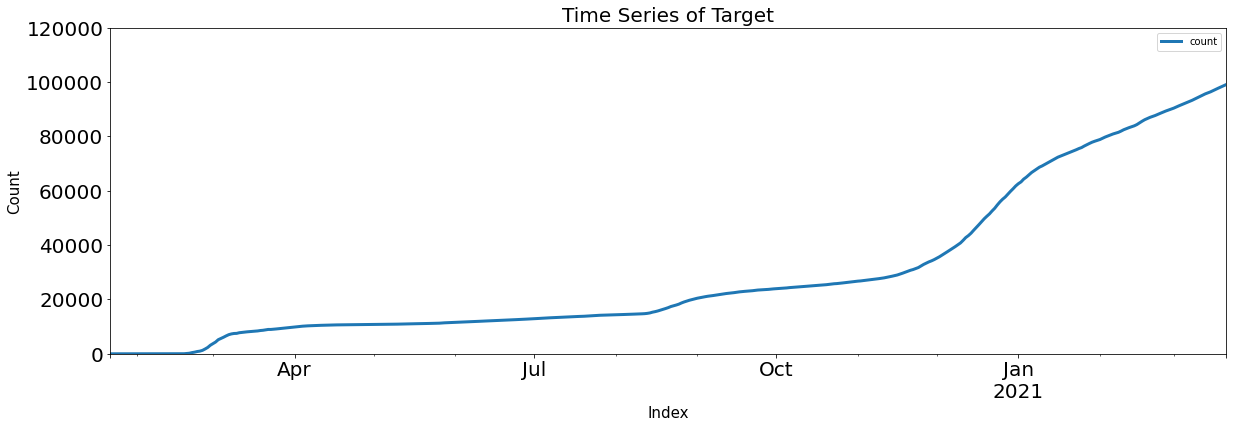

In [ ]:
df_korea[['count']].plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                              xlim=('2020-01-22', '2021-03-21'), ylim=(0,120000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

#### 계절성, 트랜드, 잔차 분리

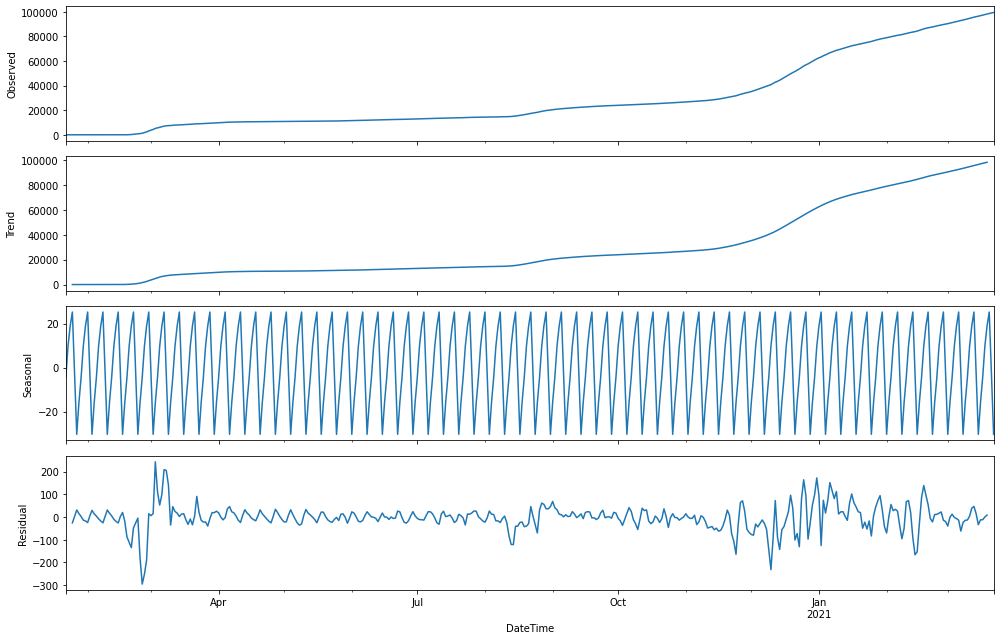

In [ ]:
# 계절성, 트랜드, 잔차 분리 그래프
import statsmodels.api as sm 
from scipy import stats
plt.rcParams['figure.figsize'] = (14, 9)
sm.tsa.seasonal_decompose(df_korea['count'], model='additive').plot()
plt.show()

In [ ]:
# 계절성과 트랜드 변수 삽입
result = sm.tsa.seasonal_decompose(df_korea['count'], model='additive')
Y_trend = pd.DataFrame(result.trend)
Y_trend.fillna(method='ffill', inplace=True)
Y_trend.fillna(method='bfill', inplace=True)
Y_trend.columns = ['count_trend']
Y_seasonal = pd.DataFrame(result.seasonal)
Y_seasonal.fillna(method='ffill', inplace=True)
Y_seasonal.fillna(method='bfill', inplace=True)
Y_seasonal.columns = ['count_seasonal']

Y_seasonal

,count_seasonal
DateTime,
2020-01-22,-4.45
2020-01-23,9.68
2020-01-24,18.94
2020-01-25,25.25
2020-01-26,-3.20
...,...
2021-03-18,9.68
2021-03-19,18.94
2021-03-20,25.25


In [ ]:
Y_trend

,count_trend
DateTime,
2020-01-22,2.43
2020-01-23,2.43
2020-01-24,2.43
2020-01-25,2.43
2020-01-26,2.86
...,...
2021-03-18,"97,747.00"
2021-03-19,"98,181.43"
2021-03-20,"98,181.43"


In [ ]:
df_korea = pd.concat([df_korea, Y_trend, Y_seasonal], axis=1)

In [ ]:
df_korea.head()

,datetime,count,count_trend,count_seasonal
DateTime,,,,
2020-01-22,2020-01-22,1,2.43,-4.45
2020-01-23,2020-01-23,1,2.43,9.68
2020-01-24,2020-01-24,2,2.43,18.94
2020-01-25,2020-01-25,2,2.43,25.25
2020-01-26,2020-01-26,3,2.86,-3.20


#### 주별패턴 확인

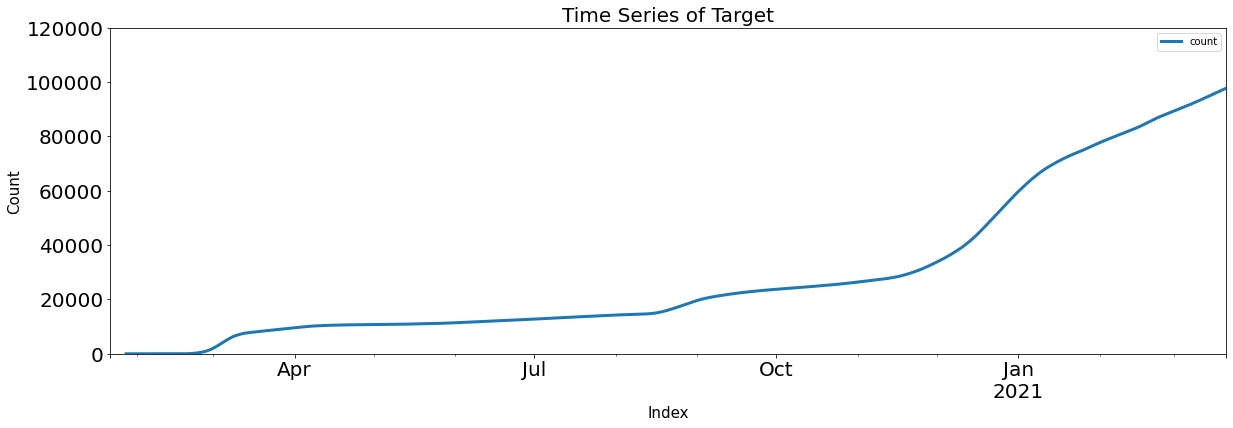

In [ ]:
# rolling(7)
df_korea[['count']].rolling(7).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2020-01-22', '2021-03-21'), ylim=(0,120000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [ ]:
Y_count_Week = df_korea[['count']].rolling(7).mean()
Y_count_Week.fillna(method='ffill', inplace=True)
Y_count_Week.fillna(method='bfill', inplace=True)
Y_count_Week.columns = ['count_Week']

In [ ]:
df_korea = pd.concat([df_korea,  Y_count_Week], axis=1)
df_korea.head()

,datetime,count,count_trend,count_seasonal,count_Week
DateTime,,,,,
2020-01-22,2020-01-22,1,2.43,-4.45,2.43
2020-01-23,2020-01-23,1,2.43,9.68,2.43
2020-01-24,2020-01-24,2,2.43,18.94,2.43
2020-01-25,2020-01-25,2,2.43,25.25,2.43
2020-01-26,2020-01-26,3,2.86,-3.20,2.43


#### 시간정보추출(Month)

In [ ]:
df_korea['Month'] = df_korea.datetime.dt.month

In [ ]:
df_korea.head()

,datetime,count,count_trend,count_seasonal,count_Week,Month
DateTime,,,,,,
2020-01-22,2020-01-22,1,2.43,-4.45,2.43,1
2020-01-23,2020-01-23,1,2.43,9.68,2.43,1
2020-01-24,2020-01-24,2,2.43,18.94,2.43,1
2020-01-25,2020-01-25,2,2.43,25.25,2.43,1
2020-01-26,2020-01-26,3,2.86,-3.20,2.43,1


In [ ]:
df_korea.info()
df_korea.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426 entries, 2020-01-22 to 2021-03-22
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        426 non-null    datetime64[ns]
 1   count           426 non-null    int64         
 2   count_trend     426 non-null    float64       
 3   count_seasonal  426 non-null    float64       
 4   count_Week      426 non-null    float64       
 5   Month           426 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 23.3 KB


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
datetime,426,426,2020-04-13,1,2020-01-22,2021-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,426.00,NaN,NaT,NaN,NaT,NaT,"29,784.47","28,295.57",1.00,"10,826.50","17,200.50","38,007.25","99,421.00"
count_trend,426.00,NaN,NaT,NaN,NaT,NaT,"29,780.39","28,276.90",2.43,"10,842.57","17,169.79","38,020.04","98,181.43"
count_seasonal,426.00,NaN,NaT,NaN,NaT,NaT,0.04,18.12,-30.31,-15.91,-3.20,18.94,25.25
count_Week,426.00,NaN,NaT,NaN,NaT,NaT,"29,088.98","27,790.95",2.43,"10,804.43","16,244.36","36,211.71","98,181.43"
Month,426.00,NaN,NaT,NaN,NaT,NaT,5.91,3.55,1.00,3.00,6.00,9.00,12.00


#### 시각화 분석

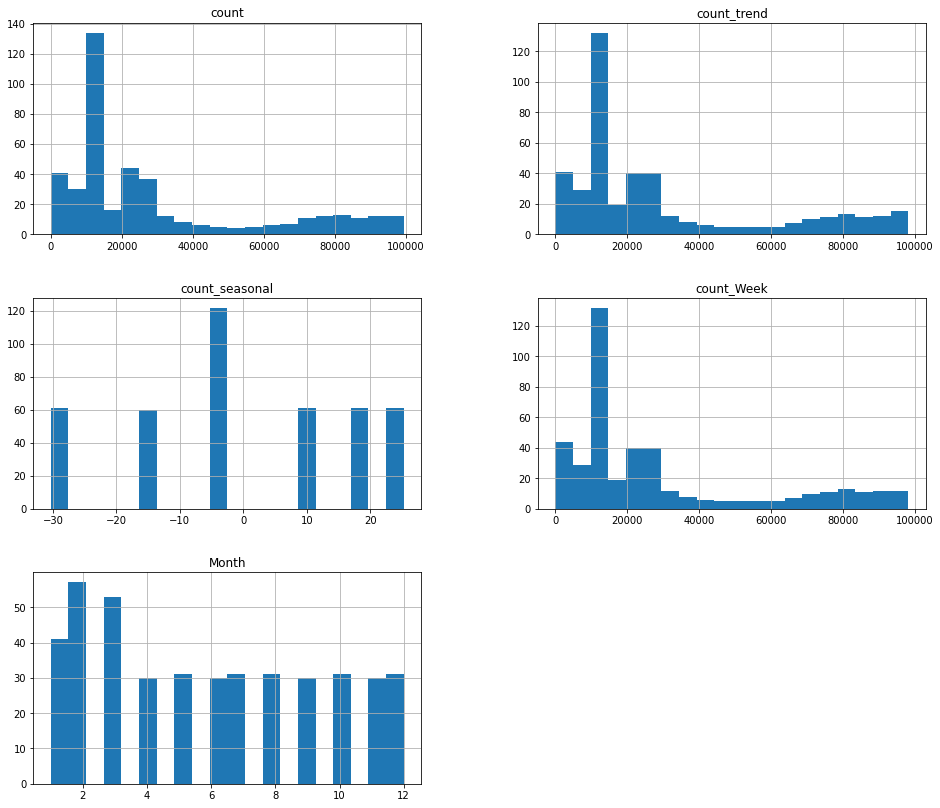

In [ ]:
df_korea.hist(bins=20, grid=True, figsize=(16,14))
plt.show()

## Step 3. 시계열 데이터분리

In [ ]:
df_korea.columns

Index(['datetime', 'count', 'count_trend', 'count_seasonal', 'count_Week',
       'Month'],
      dtype='object')

In [ ]:
Y_colname = ['count']
X_remove = ['datetime']

In [ ]:
X_colname = [x for x in df_korea.columns if x not in  Y_colname+X_remove]
len(X_colname)

4

In [ ]:
df_korea_train = df_korea.loc[df_korea.index < '2021-01-01',:]
df_korea_test = df_korea.loc[df_korea.index >= '2021-01-01',:]
print(df_korea_train.shape, df_korea_test.shape)

(345, 6) (81, 6)


In [ ]:
Y_train = df_korea_train[Y_colname]
X_train = df_korea_train[X_colname]
Y_test = df_korea_test[Y_colname]
X_test = df_korea_test[X_colname]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(345, 4) (345, 1)
(81, 4) (81, 1)


## Step 4. 시계열 딥러닝 분석

In [ ]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 7
batch_size = 16
epoch = 15
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (338, 7, 4) Y_train: (338, 1)
X_test: (74, 7, 4) Y_test: (74, 1)


#### GRU 모델링

In [ ]:
model = Sequential()
model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 256)            201216    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 7, 128)            148224    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 7, 128)            99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                3

#### 학습

In [ ]:
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

Epoch 1/15
22/22 [==============================] - 7s 55ms/step - loss: 0.0767
Epoch 2/15
22/22 [==============================] - 1s 55ms/step - loss: 0.0064
Epoch 3/15
22/22 [==============================] - 1s 59ms/step - loss: 0.0020
Epoch 4/15
22/22 [==============================] - 1s 59ms/step - loss: 5.7751e-04
Epoch 5/15
22/22 [==============================] - 1s 56ms/step - loss: 2.1212e-04
Epoch 6/15
22/22 [==============================] - 1s 54ms/step - loss: 1.8212e-04
Epoch 7/15
22/22 [==============================] - 1s 55ms/step - loss: 2.4339e-04
Epoch 8/15
22/22 [==============================] - 1s 57ms/step - loss: 1.3262e-04
Epoch 9/15
22/22 [==============================] - 1s 53ms/step - loss: 1.5000e-04
Epoch 10/15
22/22 [==============================] - 1s 55ms/step - loss: 1.1620e-04
Epoch 11/15
22/22 [==============================] - 1s 53ms/step - loss: 1.2415e-04
Epoch 12/15
22/22 [==============================] - 1s 54ms/step - loss: 1.0886e-04
E

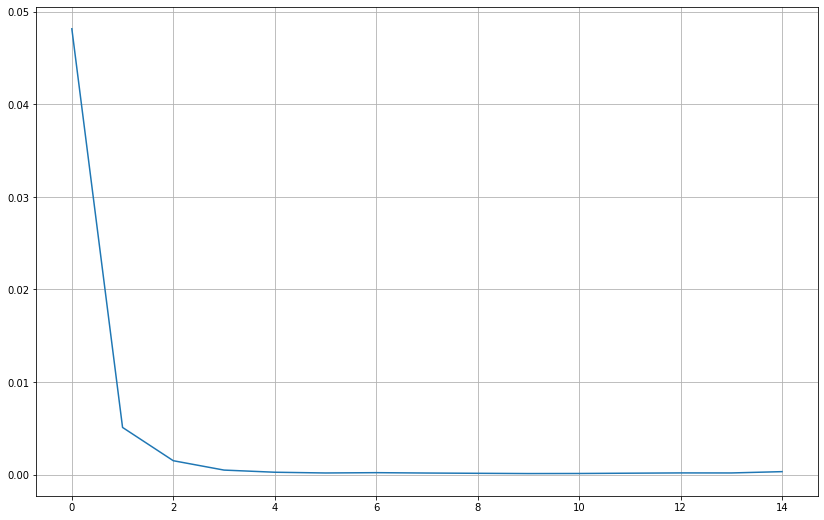

In [ ]:
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

#### 예측

3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,708.01,"752,378.16",731.58
Test,"6,898.74","57,427,479.16",8.71


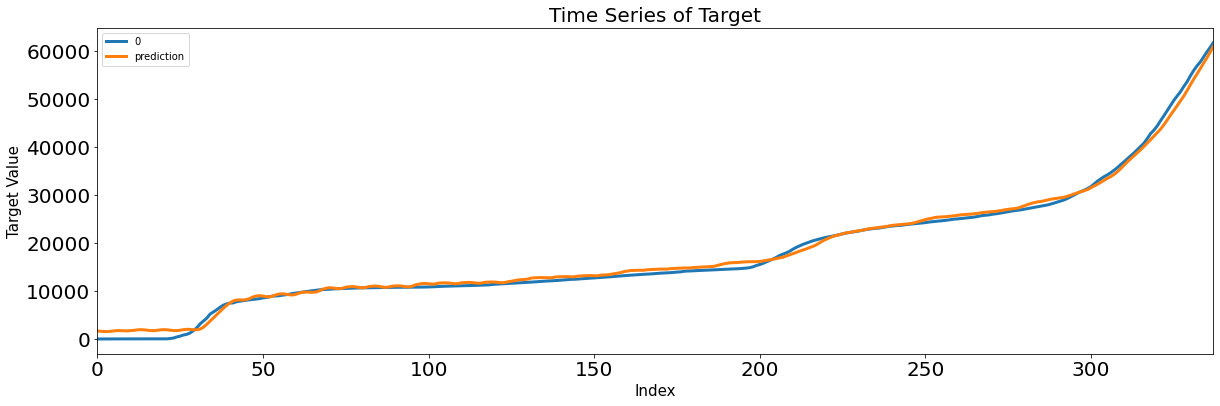

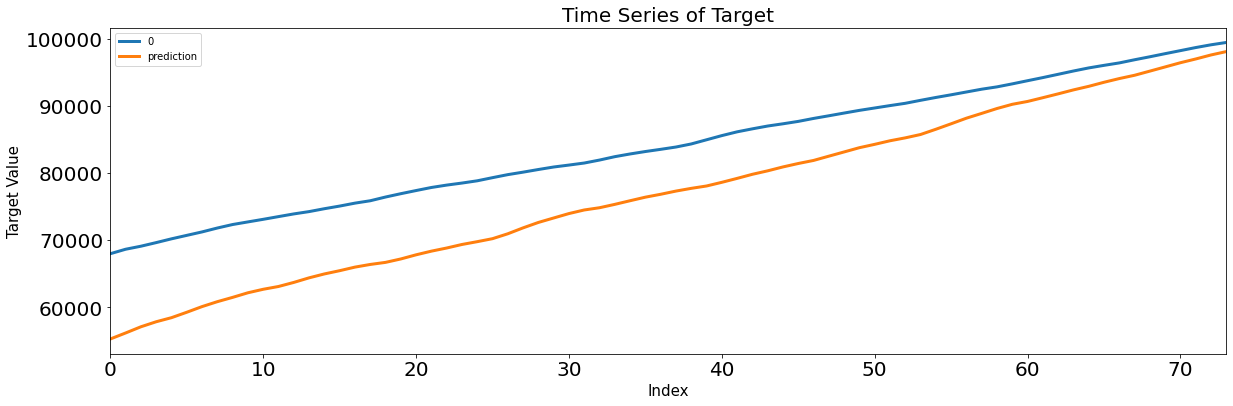

In [ ]:
# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)